# EE679 - Speech Processing

## Dadi Dharani 20D070023

## The task: To recognize an uttered word by any speaker from a command word set. Dataset: Subset of Google Speech Commands Dataset version 0.01

## Audio files: 16 kHz sampling rate, each recording is of duration of 1 second or less (unpadded), stored as 16-bit PCM (signed integers).

## The 10 words are: “down”, “go”, “left”, “no”, “off”, “on”, “right”, “stop”, “up”, “yes”

## Training set:
## Each word has about 2100 recorded instances in the training set across several different speakers. Thus, the total number of utterances in the training set is about 21,000.
## There are approx. 1060 speakers in the training set and approx. 120 speakers in the test set for each word. There is no overlapping between the speakers in the training set and the test set.
## Noise files - “doing_the_dishes.wav”, “exercise_bike.wav”, “white_noise.wav”, “dude_miaowing.wav”, “pink_noise.wav”, “running_tap.wav” (each of approx. 1 minute)
## You will use the training speech data as such or create new training data instances by adding noise to the available recordings depending on the test task at hand. Further, you can set aside a part of your training set (e.g. 20%) for validation (tuning any hyper-parameters of your models) if required.

# Method
## For this assignment, I shall use the Statistical method of HMM-GMMs for Pattern Matching

In [ ]:
#importing useful libraries
import os
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import tf2zpk, find_peaks, freqz
from scipy.io.wavfile import write
from librosa import feature
from hmmlearn import hmm
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm

In [ ]:
#Paths to data
base_path = "/Users/dharani/Study/EE679/Commands Dataset"
train_data_path = os.path.join(base_path, "train")
clean_test_data_path = os.path.join(base_path, "test_clean")
noisy_test_data_path = os.path.join(base_path, "test_noisy")

# Dataloader

In [ ]:
train_dataset = {}

for label in os.listdir(train_data_path):
    print(f"Reading '{label}' speech data")

    label_data = [wavfile.read(os.path.join(train_data_path, label, file))[1] for file in os.listdir(os.path.join(train_data_path, label))]

    normalized_label_data = [data / 32767.0 for data in label_data]

    train_dataset[label] = normalized_label_data


Reading 'right' speech data
Reading 'go' speech data
Reading 'no' speech data
Reading 'left' speech data
Reading 'stop' speech data
Reading 'up' speech data
Reading 'down' speech data
Reading 'yes' speech data
Reading 'on' speech data
Reading 'off' speech data


In [ ]:
test_clean_dataset = {}

for label in os.listdir(clean_test_data_path):
    print(f"Reading '{label}' speech data")

    label_data = [wavfile.read(os.path.join(clean_test_data_path, label, file))[1] for file in os.listdir(os.path.join(clean_test_data_path, label))]

    normalized_label_data = [data / 32767.0 for data in label_data]

    test_clean_dataset[label] = normalized_label_data

Reading 'right' speech data
Reading 'go' speech data
Reading 'no' speech data
Reading 'left' speech data
Reading 'stop' speech data
Reading 'up' speech data
Reading 'down' speech data
Reading 'yes' speech data
Reading 'on' speech data
Reading 'off' speech data


In [ ]:
test_noisy_dataset = {}

for label in os.listdir(noisy_test_data_path):
    print(f"Reading '{label}' speech data")

    label_data = [wavfile.read(os.path.join(noisy_test_data_path, label, file))[1] for file in os.listdir(os.path.join(noisy_test_data_path, label))]

    normalized_label_data = [data / 32767.0 for data in label_data]

    test_noisy_dataset[label] = normalized_label_data

Reading 'right' speech data
Reading 'go' speech data
Reading 'no' speech data
Reading 'left' speech data
Reading 'stop' speech data
Reading 'up' speech data
Reading 'down' speech data
Reading 'yes' speech data
Reading 'on' speech data
Reading 'off' speech data


# End-Pointing

### End-pointing, involves identifying and isolating the speech signal from surrounding noise or silence. The process is crucial for various speech-related applications, such as speech recognition and speaker identification.
### First, the original speech signal is plotted to visualize its amplitude variation over time.
### We then compute and plot the normalized power spectrum of the signal. A red curve is drawn, indicating the segments identified as speech based on a given threshold. The threshold is applied to distinguish speech from silence or background noise.
### The normalized power spectrum of the speech signal is visualized. This plot helps in understanding the frequency distribution of the speech signal and determine the threshold.
### The final step involves end-pointing the speech signal based on the identified segments. Only the regions classified as speech, beyond the specified threshold, are considered. The resulting end-pointed speech signal is plotted.

In [ ]:
def power_spectrum_zcr(data, sampling_rate, duration=0.02): #
    samples = int(sampling_rate * duration)
    hamming_window = np.hamming(samples)
    zero_crossings = []
    powers = []

    half_samples = samples // 2
    padded_data = np.pad(data, (half_samples, half_samples), 'constant')

    for i in range(half_samples, data.shape[0]):
        windowed_data = padded_data[i - half_samples:i + half_samples] * hamming_window
        powers.append(np.sum(windowed_data ** 2))

    powers = np.where(np.array(powers) > 1e-18, np.array(powers), -20)

    if max(powers) == 0:
        return 10 * np.log10(powers, out=powers, where=powers > 0), np.array(zero_crossings)
    else:
        return 10 * np.log10(powers / max(powers), out=powers / max(powers), where=powers / max(powers) > 0), np.array(zero_crossings)

def apply_threshold(data, sampling_rate, threshold, duration=0.02):
    power_spectrum, _ = power_spectrum_zcr(data, sampling_rate=sampling_rate, duration=duration)
    speech_flags = check_threshold(power_spectrum, threshold)
    indices = np.where(speech_flags == 1.0)
    return data[indices[0][0]:indices[0][-1]]

def check_threshold(power_spectrum, threshold):
    check = []
    for i in power_spectrum:
        if i>=threshold:
            check.append(1.0)
        else:
            check.append(0.0)
    return np.array(check)


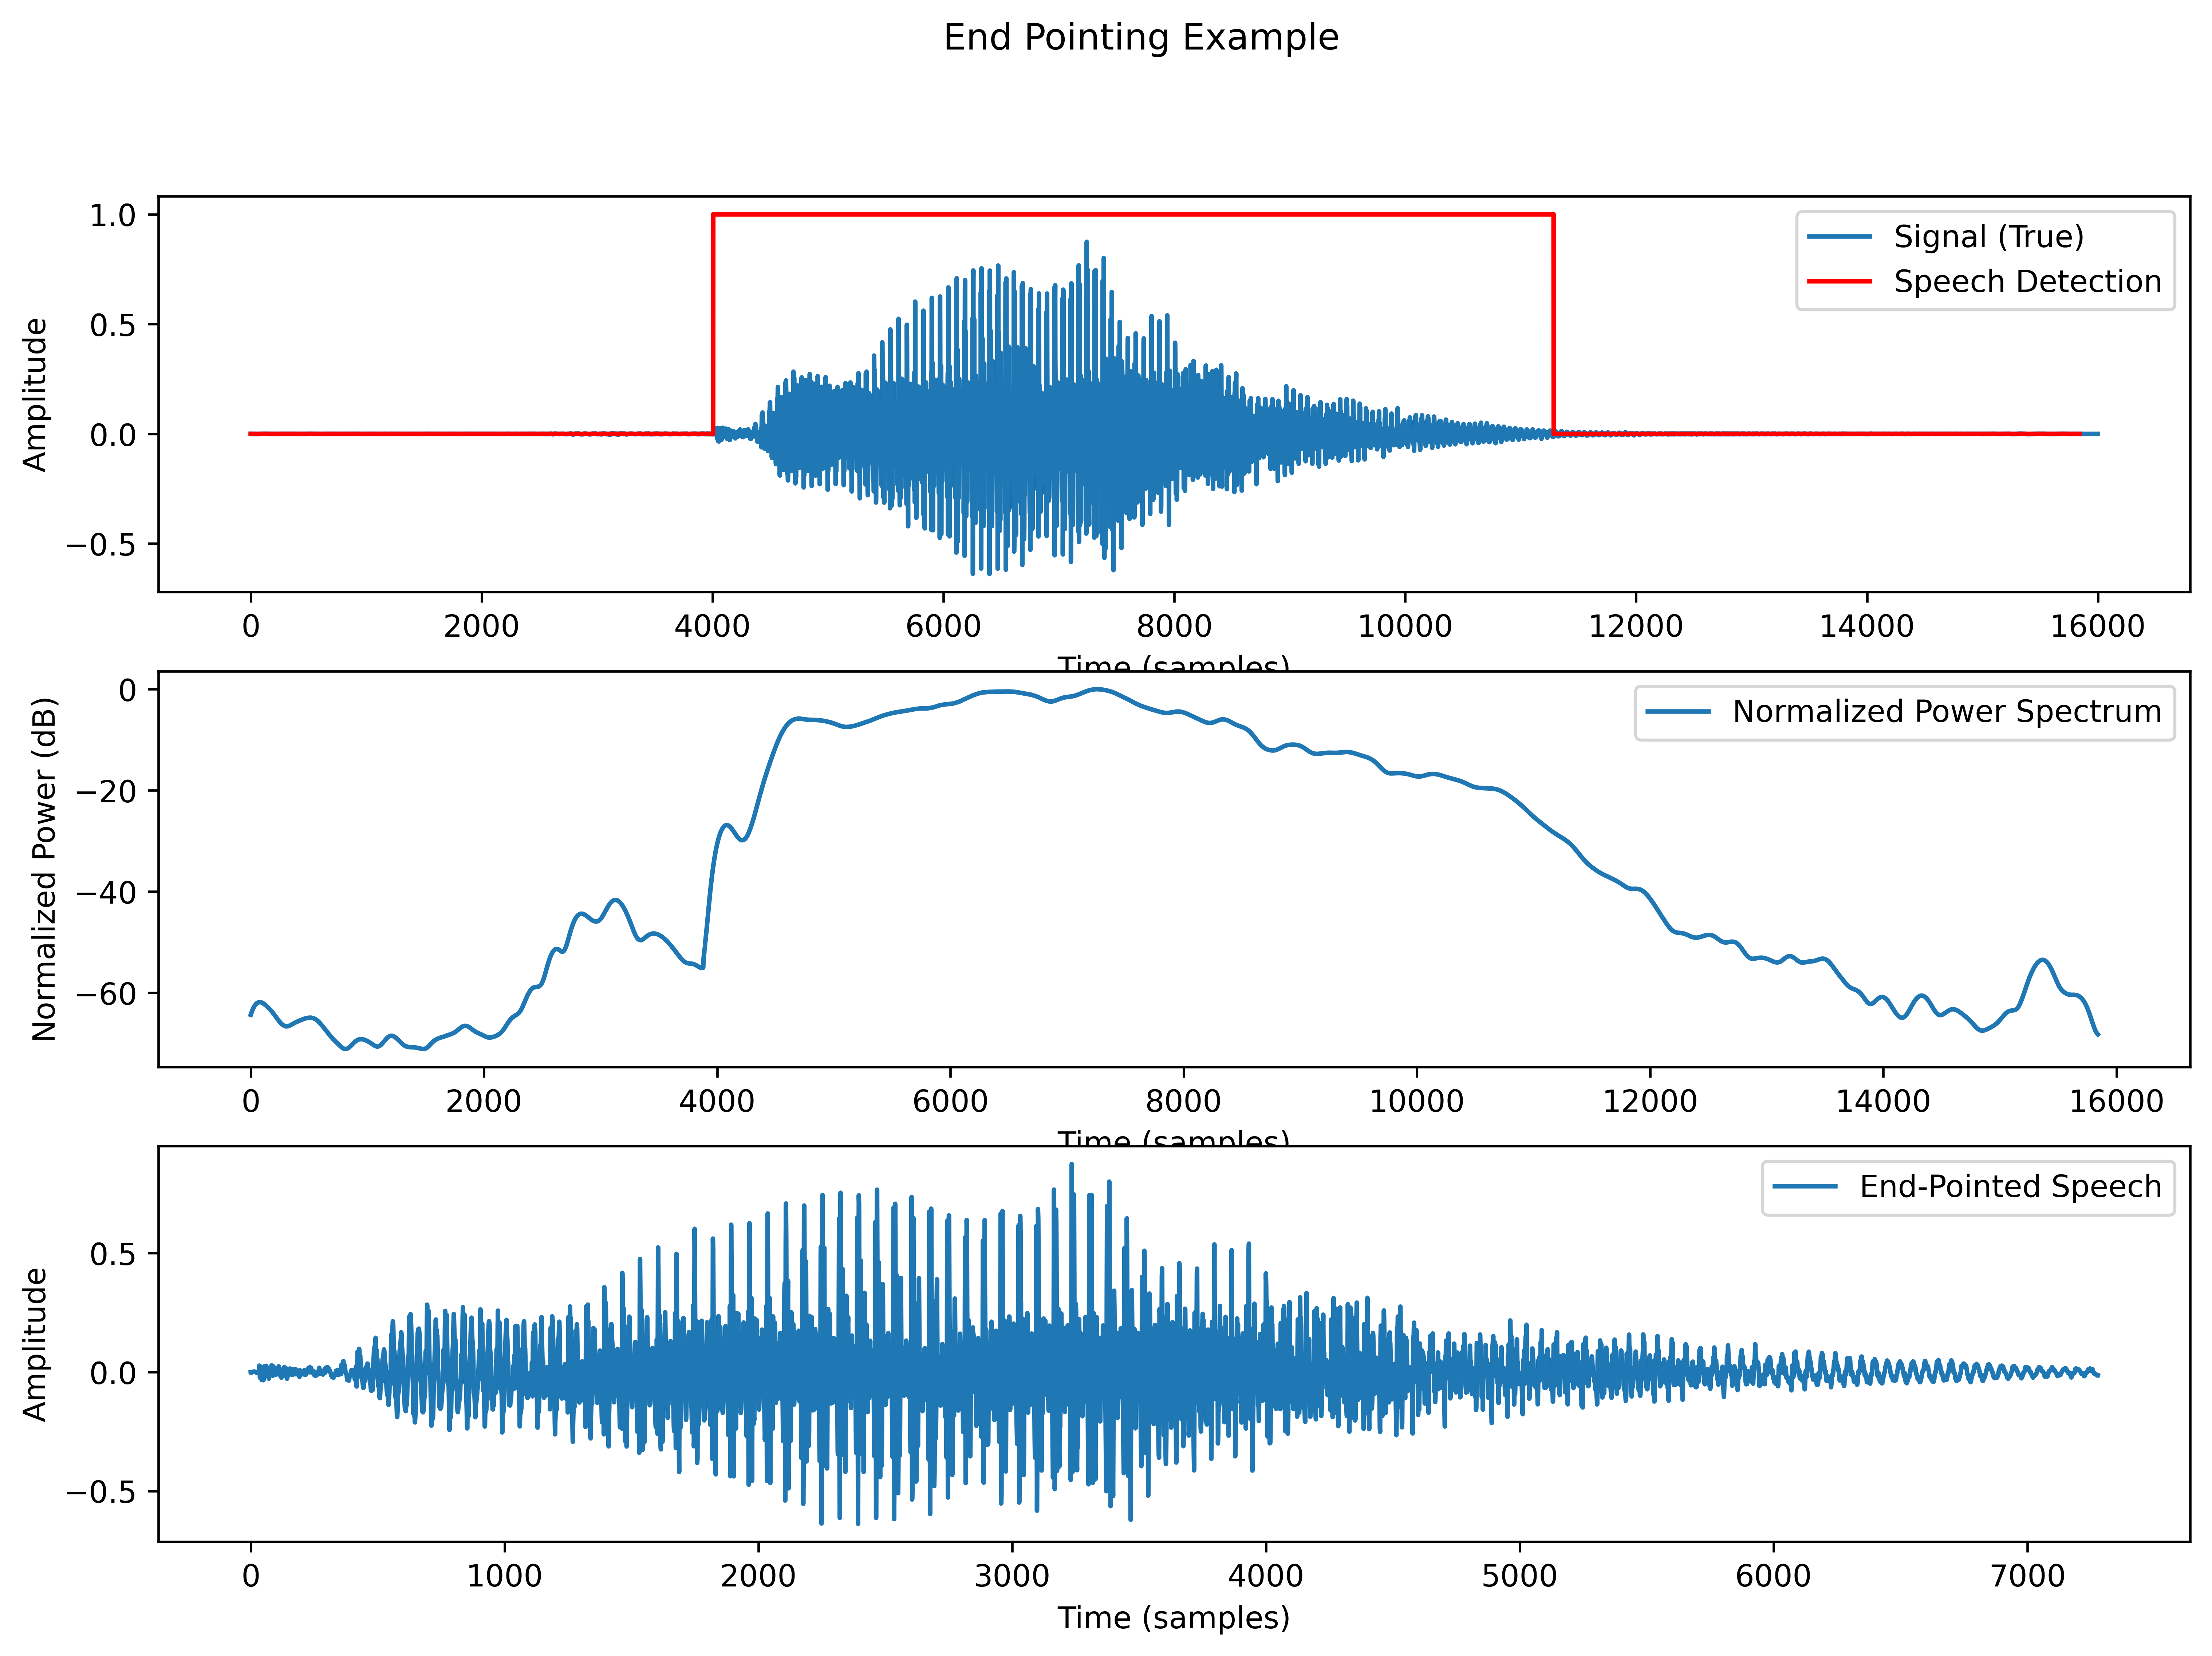

In [ ]:
def plot_end_pointing_example(dataset, sample_rate=16000, threshold=-30, duration=0.02):
    plt.figure(figsize=(12, 8))
    plt.tight_layout(pad=1)

    index = np.random.randint(1, 100)
    str_indicator = 'down'
    signal = dataset[str_indicator][index]

    plt.suptitle("End Pointing Example")

    plt.subplot(311)
    plt.plot(signal, label="Signal (True)")

    power_spectrum, speech_detection = power_spectrum_zcr(signal, sample_rate)
    #print(check_threshold(power_spectrum, -30))
    plt.plot(check_threshold(power_spectrum, -30), 'r', label="Speech Detection")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.subplot(312)
    #power_spectrum, _ = power_spectrum_zcr(signal, sample_rate, duration)
    plt.plot(power_spectrum, label="Normalized Power Spectrum")
    plt.xlabel("Time (samples)")
    plt.ylabel("Normalized Power (dB)")
    plt.legend()

    plt.subplot(313)
    end_pointed_speech = apply_threshold(signal, sample_rate, threshold, duration)
    plt.plot(end_pointed_speech, label="End-Pointed Speech")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.show()

# Call the function with your dataset
plot_end_pointing_example(train_dataset)

# Pre-Processing Data

## We define a function to perform pre-emphasis on the end-pointed speech. End-pointing is performed with a threshold of -30dB

In [ ]:
#Pre-emphasis filter
def apply_preemphasis(input_data, preemphasis_coefficient=0.95):
    preemphasized_data = [input_data[n] - preemphasis_coefficient * input_data[n - 1] for n in range(1, len(input_data))]
    preemphasized_data = np.insert(preemphasized_data, 0, input_data[0])
    return preemphasized_data

In [ ]:
#Pre-Processing Train Data
trainLabels = [label for label in os.listdir(train_data_path)]
train_data_pre_processed = {}
for label in trainLabels:
    print(f"Preprocessing '{label}' speech data")
    processed_samples = []

    for sample in train_dataset[label]:
        end_pointed_signal = apply_threshold(sample, 16000, threshold=-30, duration=0.02) #End-pointing

        pre_emphasized_signal = apply_preemphasis(end_pointed_signal, 0.95) #Pre-emphasis

        processed_samples.append(pre_emphasized_signal)

    train_data_pre_processed[label] = processed_samples

Preprocessing 'right' speech data


In [ ]:
clean_test_labels = [label for label in os.listdir(clean_test_data_path)]
clean_test_data_pre_processed = {}
for label in clean_test_labels:
    print(f"Pre processing '{label}' speech data")
    processed_samples = []

    for sample in test_clean_dataset[label]:
        end_pointed_signal = apply_threshold(sample, 16000, threshold=-30, duration=0.02) #End-pointing

        pre_emphasized_signal = apply_preemphasis(end_pointed_signal, 0.95) #Pre-emphasis

        processed_samples.append(pre_emphasized_signal)

    clean_test_data_pre_processed[label] = processed_samples

Pre processing 'right' speech data
Pre processing 'go' speech data
Pre processing 'no' speech data
Pre processing 'left' speech data
Pre processing 'stop' speech data
Pre processing 'up' speech data
Pre processing 'down' speech data
Pre processing 'yes' speech data
Pre processing 'on' speech data
Pre processing 'off' speech data


In [ ]:
noisy_test_labels = [label for label in os.listdir(noisy_test_data_path)]
noisy_test_data_pre_processed = {}
for label in noisy_test_labels:
    print(f"Pre processing '{label}' speech data")
    processed_samples = []

    for sample in test_noisy_dataset[label]:
        end_pointed_signal = apply_threshold(sample, 16000, threshold=-30, duration=0.02) #End-pointing

        pre_emphasized_signal = apply_preemphasis(end_pointed_signal, 0.95) #Pre-emphasis

        processed_samples.append(pre_emphasized_signal)

    noisy_test_data_pre_processed[label] = processed_samples

Pre processing 'right' speech data
Pre processing 'go' speech data
Pre processing 'no' speech data
Pre processing 'left' speech data
Pre processing 'stop' speech data
Pre processing 'up' speech data
Pre processing 'down' speech data
Pre processing 'yes' speech data
Pre processing 'on' speech data
Pre processing 'off' speech data


# MFCC Feature Extraction
## We generate MFCC coefficients for each utterance with length of Mel Filter Bank as 13.

In [ ]:
mfcc_vec_train = {}
for label in trainLabels:
    print(f"Finding MFCC Coeff for '{label}'")
    mfcc_label = []
    for i in range(len(train_data_pre_processed[label])):
        mfcc_Features = feature.mfcc(y=train_data_pre_processed[label][i], sr=16000, n_mfcc=13)
        d1 = feature.delta(mfcc_Features, order=1, mode = 'nearest')
        d2 = feature.delta(mfcc_Features, order=2, mode = 'nearest')
        mfcc_label.append(np.r_[mfcc_Features, d1, d2])
    mfcc_vec_train[label] = mfcc_label

In [ ]:
mfcc_vec_test_clean = {}
for label in clean_test_labels:
    print(f"Finding MFCC Coeff for '{label}'")
    mfcc_label = []
    for i in range(len(clean_test_data_pre_processed[label])):
        mfcc_Features = feature.mfcc(y=clean_test_data_pre_processed[label][i], sr=16000, n_mfcc=13)
        d1 = feature.delta(mfcc_Features, order=1, mode = 'nearest')
        d2 = feature.delta(mfcc_Features, order=2, mode = 'nearest')
        mfcc_label.append(np.r_[mfcc_Features, d1, d2])
    mfcc_vec_test_clean[label] = mfcc_label

In [ ]:
mfcc_vec_test_noisy = {}
for label in noisy_test_labels:
    print(f"Finding MFCC Coeff for '{label}'")
    mfcc_label = []
    for i in range(len(noisy_test_data_pre_processed[label])):
        mfcc_Features = feature.mfcc(y=noisy_test_data_pre_processed[label][i], sr=16000, n_mfcc=13)
        d1 = feature.delta(mfcc_Features, order=1, mode = 'nearest')
        d2 = feature.delta(mfcc_Features, order=2, mode = 'nearest')
        mfcc_label.append(np.r_[mfcc_Features, d1, d2])
    mfcc_vec_test_noisy[label] = mfcc_label

Finding MFCC Coeff for 'right'
Finding MFCC Coeff for 'go'
Finding MFCC Coeff for 'no'
Finding MFCC Coeff for 'left'
Finding MFCC Coeff for 'stop'
Finding MFCC Coeff for 'up'
Finding MFCC Coeff for 'down'
Finding MFCC Coeff for 'yes'
Finding MFCC Coeff for 'on'
Finding MFCC Coeff for 'off'


# Training the HMM Model

## The HMM Model is trained with 9 HMM states and each state with 3 GMMs.

In [ ]:
from tqdm import tqdm

trained_model = {}
hmm_states = 9
gmm_states = 3

for word in tqdm(mfcc_vec_train.keys(), desc="Training models"):

    model = hmm.GMMHMM(n_components=hmm_states, n_mix=gmm_states, n_iter=10, covariance_type='full')

    sequence_lengths = np.zeros([len(mfcc_vec_train[word]), ], dtype=int)
    for i in range(0, len(mfcc_vec_train[word])):
        sequence_lengths[i] = mfcc_vec_train[word][i].shape[1]

    current_train_data = mfcc_vec_train[word][0].T
    for i in range(1, len(mfcc_vec_train[word])):
        current_train_data = np.vstack((current_train_data, mfcc_vec_train[word][i].T))

    model.fit(current_train_data, lengths=sequence_lengths)

    trained_model[word] = model



Training models: 100%|█████████████████████████| 10/10 [46:51<00:00, 281.14s/it]


# Testing on Clean Test Data

In [ ]:
clean_test_predictions = {}

for test_utt in tqdm(mfcc_vec_train.keys(), desc="Testing models"):
    frame_predictions = []

    for frame_idx in range(len(mfcc_vec_test_clean[test_utt])):
        frame_scores = []

        for word in mfcc_vec_train.keys():
            frame_scores.append(trained_model[word].score(mfcc_vec_test_clean[test_utt][frame_idx].T))

        predicted_word = list(mfcc_vec_train.keys())[frame_scores.index(max(frame_scores))]
        frame_predictions.append(predicted_word)

    clean_test_predictions[test_utt] = frame_predictions

Testing models: 100%|████████████████████| 10/10 [05:23<00:00, 32.34s/utterance]


In [ ]:
accuracy_test_clean = {}

for test_utt in mfcc_vec_train.keys():
    word_accuracies = []

    for word in mfcc_vec_train.keys():
        word_accuracy = 0

        for prediction in clean_test_predictions[test_utt]:
            if prediction == word:
                word_accuracy += 1

        word_accuracies.append(word_accuracy / len(mfcc_vec_test_clean[test_utt]))

    accuracy_test_clean[test_utt] = word_accuracies


# Testing on Noisy Test Data

In [ ]:
noisy_test_predictions = {}

for test_utt in tqdm(mfcc_vec_train.keys(), desc="Testing models"):
    frame_predictions = []

    for frame_idx in range(len(mfcc_vec_test_clean[test_utt])):
        frame_scores = []

        for word in mfcc_vec_train.keys():
            frame_scores.append(trained_model[word].score(mfcc_vec_test_noisy[test_utt][frame_idx].T))

        predicted_word = list(mfcc_vec_train.keys())[frame_scores.index(max(frame_scores))]
        frame_predictions.append(predicted_word)

    noisy_test_predictions[test_utt] = frame_predictions

Testing models: 100%|████████████████████| 10/10 [05:09<00:00, 30.98s/utterance]


In [ ]:
accuracy_test_noisy = {}

for test_utt in mfcc_vec_train.keys():
    word_accuracies = []

    for word in mfcc_vec_train.keys():
        word_accuracy = 0

        for prediction in noisy_test_predictions[test_utt]:
            if prediction == word:
                word_accuracy += 1

        word_accuracies.append(word_accuracy / len(mfcc_vec_test_noisy[test_utt]))

    accuracy_test_noisy[test_utt] = word_accuracies

# Visualising Accuracies for the Models on Test Data

In [ ]:
#DataFrame for Clean Test Accuracies
df_accuracy_test_clean = pd.DataFrame.from_dict(accuracy_test_clean)
dictLabels = {}
for i in range(len(trainLabels)):
    dictLabels[i] = trainLabels[i]+" (pred)"
df_accuracy_test_clean = df_accuracy_test_clean.rename(index=dictLabels)
df_accuracy_test_clean

right        go        no      left      stop        up  \
right (pred)  0.984556  0.003984  0.000000  0.000000  0.000000  0.000000   
go (pred)     0.003861  0.964143  0.031746  0.000000  0.012048  0.003676   
no (pred)     0.000000  0.011952  0.932540  0.000000  0.000000  0.000000   
left (pred)   0.000000  0.000000  0.007937  0.992509  0.004016  0.000000   
stop (pred)   0.000000  0.000000  0.003968  0.003745  0.979920  0.000000   
up (pred)     0.000000  0.000000  0.003968  0.000000  0.004016  0.985294   
down (pred)   0.003861  0.011952  0.007937  0.000000  0.000000  0.000000   
yes (pred)    0.000000  0.000000  0.000000  0.003745  0.000000  0.000000   
on (pred)     0.000000  0.003984  0.000000  0.000000  0.000000  0.003676   
off (pred)    0.007722  0.003984  0.011905  0.000000  0.000000  0.007353   

                  down       yes        on       off  
right (pred)  0.000000  0.007812  0.000000  0.000000  
go (pred)     0.011858  0.000000  0.004065  0.000000  
no (pred)     0.027668  0.000000  0.000000  0.000000  
left (pred)   0.000000  0.003906  0.004065  0.000000  
stop (pred)   0.003953  0.000000  0.004065  0.000000  
up (pred)     0.000000  0.000000  0.004065  0.011450  
down (pred)   0.952569  0.007812  0.000000  0.000000  
yes (pred)    0.000000  0.972656  0.000000  0.000000  
on (pred)     0.000000  0.000000  0.983740  0.007634  
off (pred)    0.003953  0.007812  0.000000  0.980916

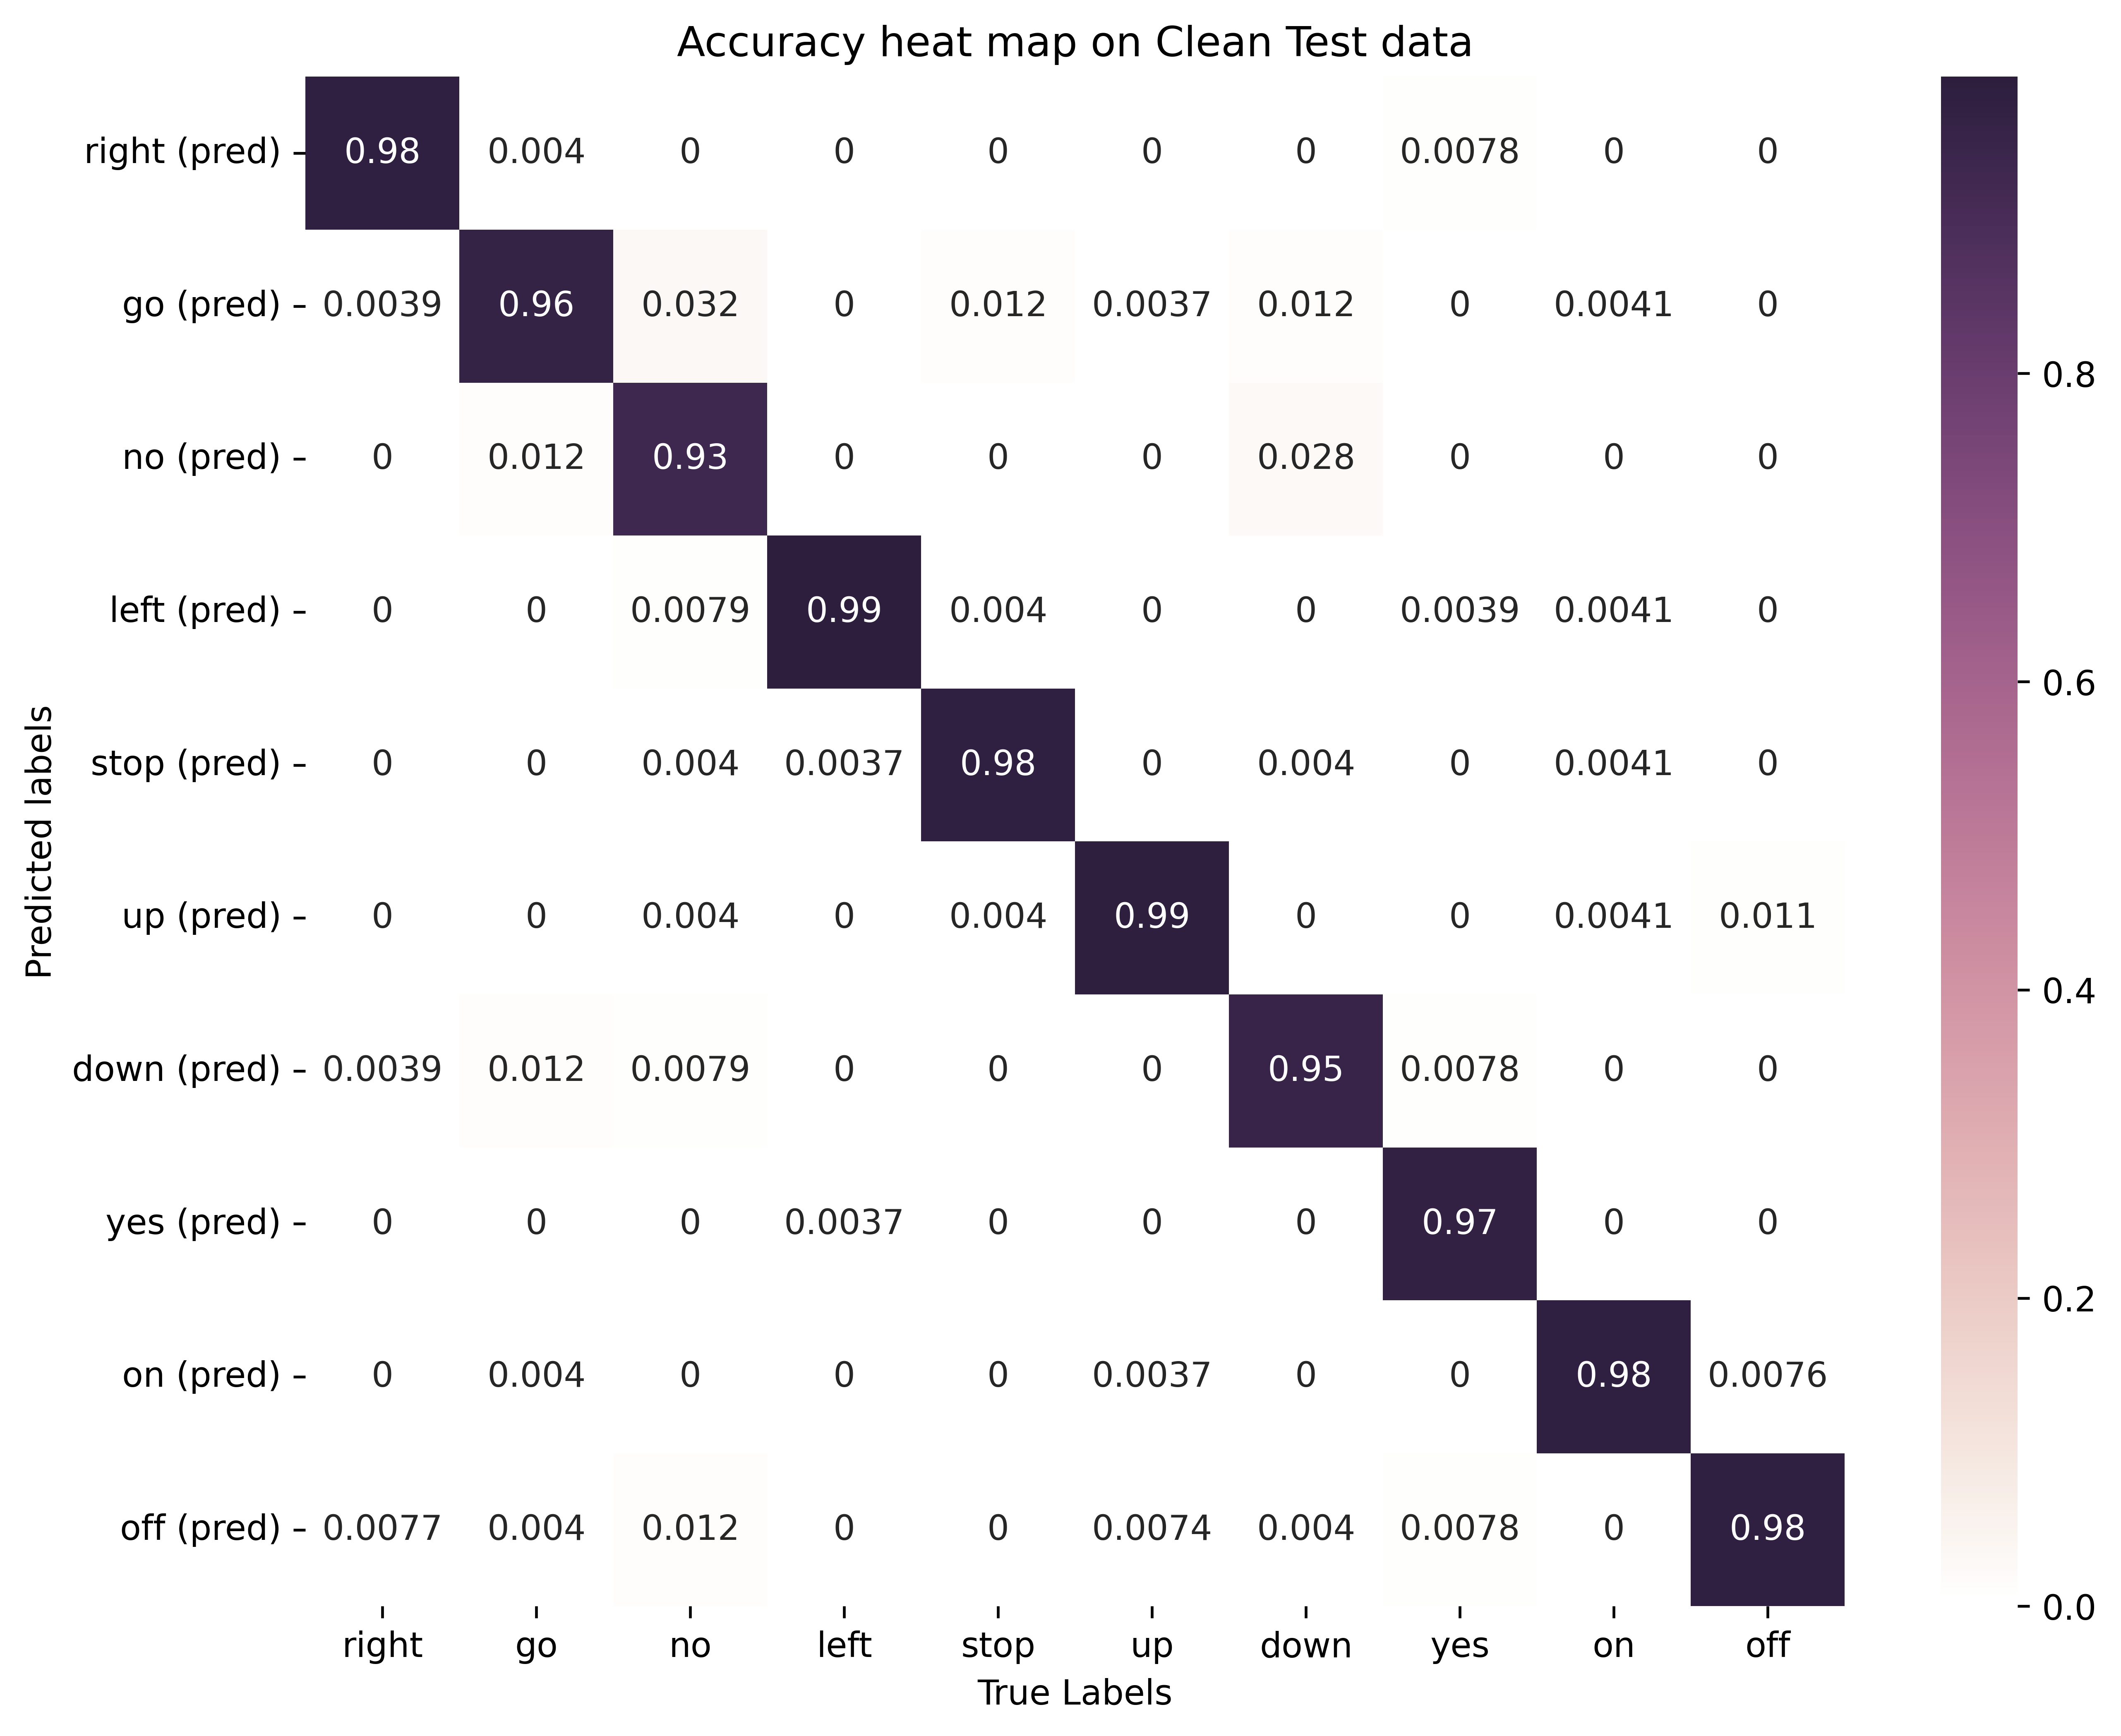

In [ ]:
plt.rcParams['figure.dpi'] = 600
fig, ax = plt.subplots(figsize=(10, 8))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
s = sns.heatmap(df_accuracy_test_clean, cmap=cmap, annot=True)
s.set_xlabel('True Labels', fontsize=10)
s.set_ylabel('Predicted labels', fontsize=10)
s.set_title("Accuracy heat map on Clean Test data")
plt.show()

In [ ]:
#DataFrame for Noisy Test Accuracies
df_accuracy_test_noisy = pd.DataFrame.from_dict(accuracy_test_noisy)
dictLabels = {}
for i in range(len(trainLabels)):
    dictLabels[i] = trainLabels[i]+" (pred)"
df_accuracy_test_noisy = df_accuracy_test_noisy.rename(index=dictLabels)
df_accuracy_test_noisy

right        go        no      left      stop        up  \
right (pred)  0.737452  0.000000  0.000000  0.003745  0.000000  0.000000   
go (pred)     0.003861  0.764940  0.146825  0.007491  0.020080  0.014706   
no (pred)     0.000000  0.003984  0.527778  0.000000  0.000000  0.000000   
left (pred)   0.073359  0.003984  0.031746  0.842697  0.036145  0.029412   
stop (pred)   0.038610  0.047809  0.023810  0.007491  0.702811  0.014706   
up (pred)     0.011583  0.011952  0.011905  0.011236  0.020080  0.757353   
down (pred)   0.003861  0.023904  0.075397  0.003745  0.008032  0.003676   
yes (pred)    0.077220  0.011952  0.027778  0.093633  0.016064  0.007353   
on (pred)     0.000000  0.003984  0.000000  0.000000  0.000000  0.000000   
off (pred)    0.054054  0.127490  0.154762  0.029963  0.196787  0.172794   

                  down       yes        on       off  
right (pred)  0.000000  0.003906  0.000000  0.000000  
go (pred)     0.079051  0.007812  0.036585  0.003817  
no (pred)     0.007905  0.000000  0.004065  0.000000  
left (pred)   0.015810  0.019531  0.000000  0.003817  
stop (pred)   0.023715  0.003906  0.016260  0.003817  
up (pred)     0.000000  0.007812  0.000000  0.011450  
down (pred)   0.723320  0.007812  0.004065  0.000000  
yes (pred)    0.035573  0.906250  0.000000  0.000000  
on (pred)     0.000000  0.000000  0.617886  0.003817  
off (pred)    0.114625  0.042969  0.321138  0.973282

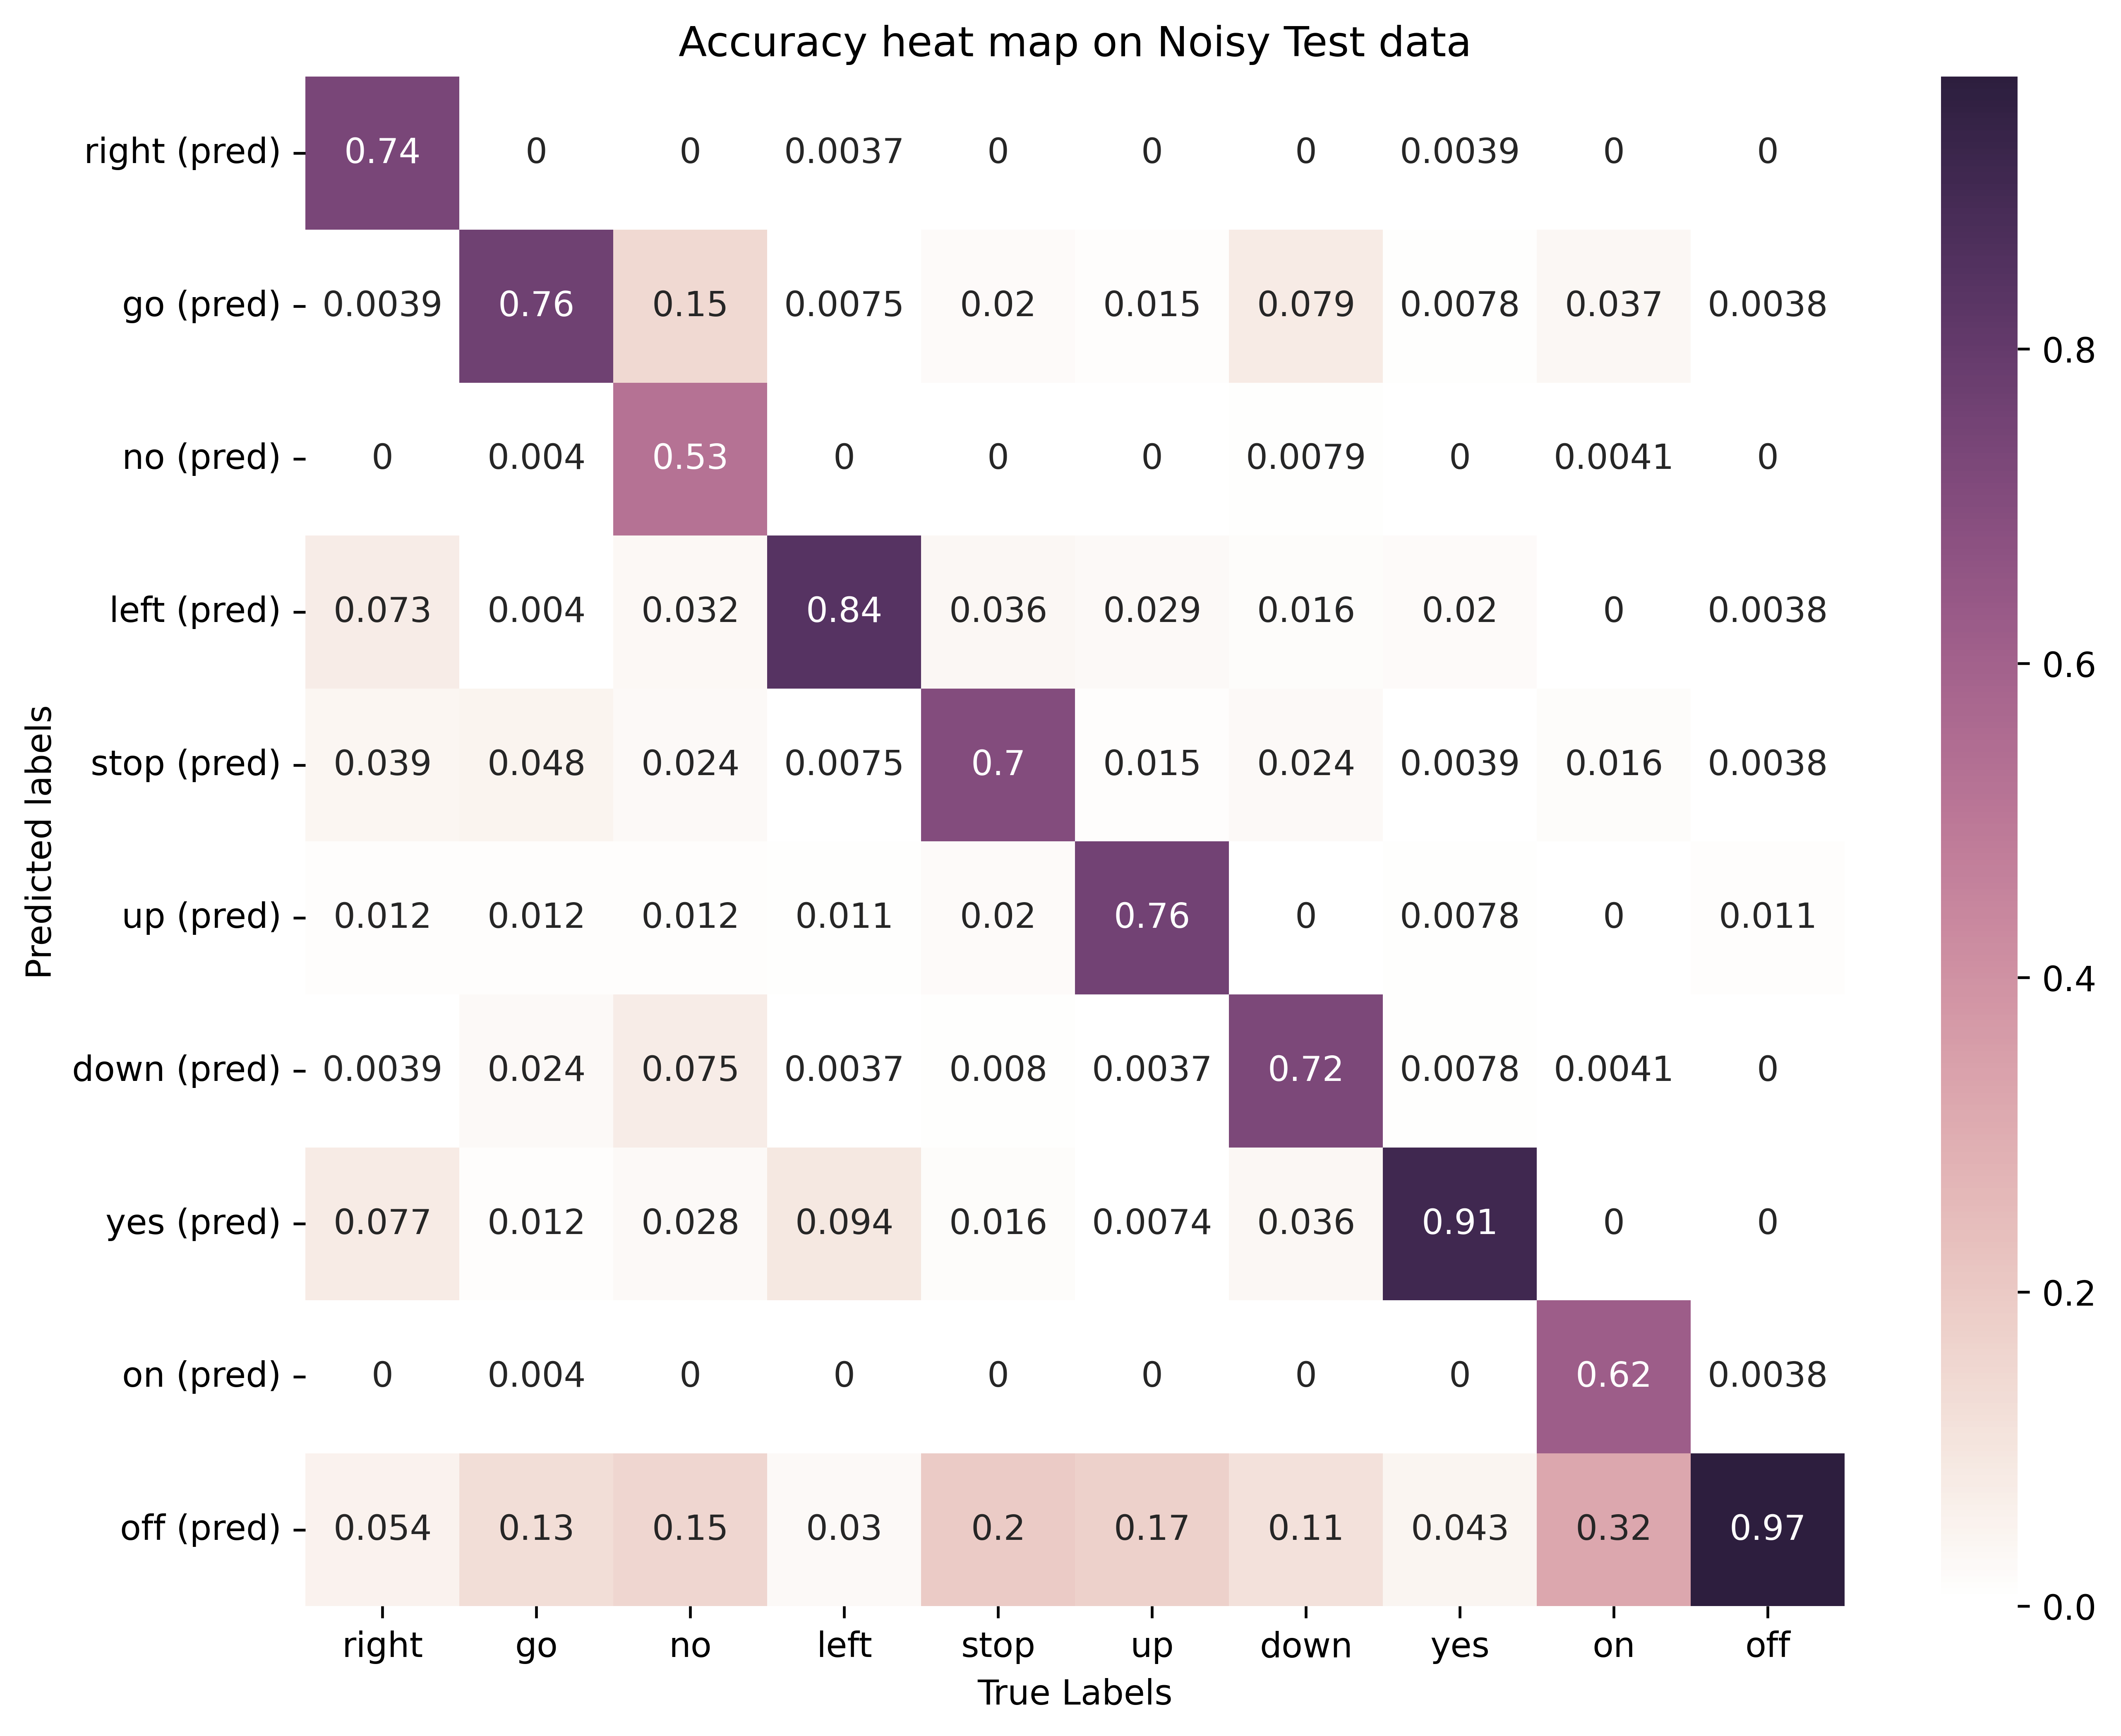

In [ ]:
plt.rcParams['figure.dpi'] = 600
fig, ax = plt.subplots(figsize=(10, 8))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
s = sns.heatmap(df_accuracy_test_noisy, cmap=cmap, annot=True)
s.set_xlabel('True Labels', fontsize=10)
s.set_ylabel('Predicted labels', fontsize=10)
s.set_title("Accuracy heat map on Noisy Test data")
plt.show()

# Observations

## Our HMM-GMM model performs extremely well on the Clean Test Data, with mean accuracy = 0.971, minimum accuracy as 0.93 and maximum accuracy as 0.99.
## However the model doesn't perform as well on the Noisy Test Data, with mean accuracy = 0.755, minimum accuracy as 0.53 and maximum accuracy as 0.97. The added noise in the utterances makes it harder for the HMM Model to classify an utterance to its correct label.

## To improve accuracy on the Noisy Test Data, we will train our Model with added Noise to the train dataset.

In [ ]:
#Customised funtion to add noise
def add_noise(speech, noise):

    #reading the .wav files
    #sampFreq, noise = wavfile.read(noisefile)
    #sampFreq, speech = wavfile.read(speechfile)
    numSamples = len(speech)

    #clipping a segment of noise from a random position, with segment length equal to the length of speech
    i = np.random.choice(np.arange(len(noise) - numSamples))
    noise = noise[i:i+numSamples]

    #converting the PCM values to floats with range from -1.0 to 1.0
    #speech = speech/32768
    #noise = noise/32768

    #normalizing the noise and adding it to the speech
    rawEnergy = np.sum(speech**2)
    noise = noise*(np.sqrt(rawEnergy/(10*np.sum(noise**2))))
    noisy_speech = speech + noise

    #normalizing the noisy speech so that its energy equals the energy of raw speech
    noisy_speech = noisy_speech*(np.sqrt(rawEnergy/np.sum(speech**2)))

    #converting the floats back to PCM values
    #speech = speech*32767
    #speech = speech.astype(np.int16)

    #saving the noisy speech to the output file
    #wavfile.write(outputfile, sampFreq, speech)

    return noisy_speech

## Loading Noise Data

In [ ]:
noise_data_path = os.path.join(base_path, "_background_noise_")

noise_dataset = {}

for file in os.listdir(noise_data_path):
    print(f"Reading '{file}' noise data")

    file_data = wavfile.read(os.path.join(noise_data_path, file))[1]

    normalized_file_data = file_data / 32767.0

    noise_dataset[file] = normalized_file_data

Reading 'pink_noise.wav' noise data
Reading 'white_noise.wav' noise data
Reading 'dude_miaowing.wav' noise data
Reading 'doing_the_dishes.wav' noise data
Reading 'exercise_bike.wav' noise data
Reading 'running_tap.wav' noise data


/var/folders/4n/ycfjt5s9315c0dkp6jw93g500000gn/T/ipykernel_1451/3599134814.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_data = wavfile.read(os.path.join(noise_data_path, file))[1]


## Added Noise Data Example

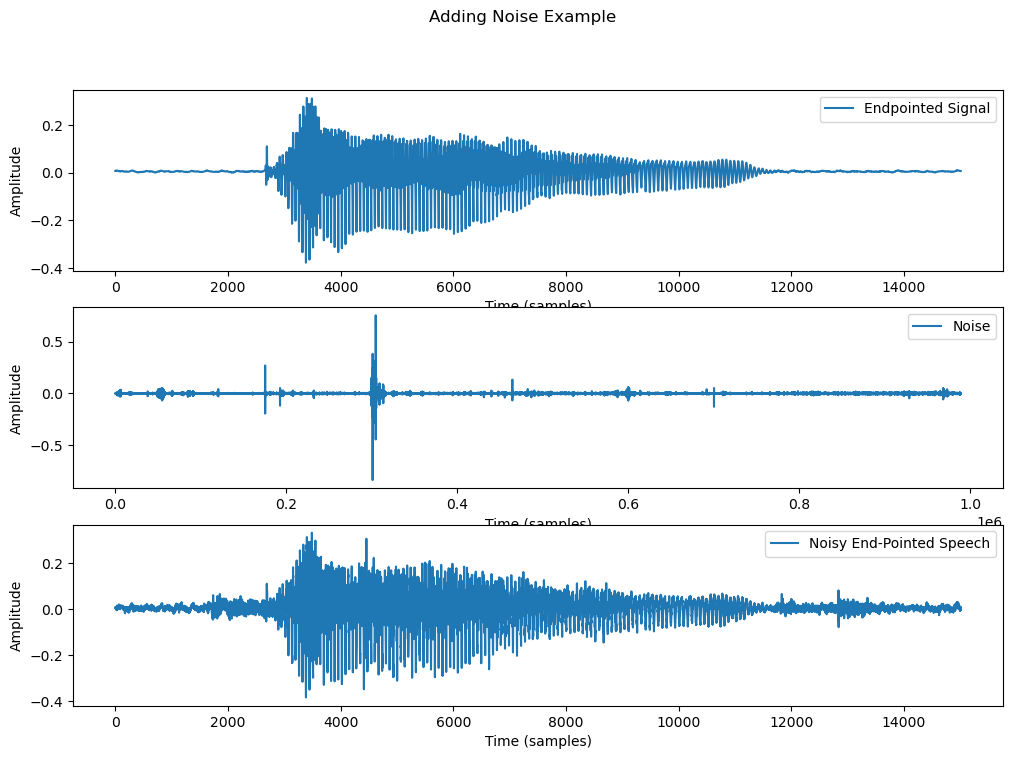

In [ ]:
def plot_noise_example(dataset, sample_rate=16000, threshold=-30, duration=0.02):
    plt.figure(figsize=(12, 8))
    plt.tight_layout(pad=1)

    index = np.random.randint(1, 100)
    str_indicator = 'down'
    signal = dataset[str_indicator][index]
    end_pointed_signal = apply_threshold(signal, 16000, threshold=-30, duration=0.02) #End-pointing

    plt.suptitle("Adding Noise Example")

    plt.subplot(311)
    plt.plot(end_pointed_signal, label="Endpointed Signal")

    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()

    noise_type = random.choice(list(noise_dataset.keys()))
    noisy_end_pointed_signal = add_noise(end_pointed_signal, noise_dataset[noise_type])

    plt.subplot(312)
    #power_spectrum, _ = power_spectrum_zcr(signal, sample_rate, duration)
    plt.plot(noise_dataset[noise_type], label="Noise")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.subplot(313)
    end_pointed_speech = apply_threshold(signal, sample_rate, threshold, duration)
    plt.plot(noisy_end_pointed_signal, label="Noisy End-Pointed Speech")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.show()

# Call the function with your dataset
plot_noise_example(train_dataset)

## We will Pre-process the train data again. For this experiment, we will add noise to the train data after end-pointing and before pre-emphasis.
## Noise will be added to any speech utterance with probability 0.5 and any among the 6 noisefiles is equally probable.
## With the Model trained on this modified dataset, we expect to achieve higher accuracies on the Noise Test Data without sacrificing siginifcantly on accuracy on the Clean Test Data.

In [ ]:
#Pre-Processing Modified Train Data
trainLabels = [label for label in os.listdir(train_data_path)]
noisy_train_data_pre_processed = {}
for label in  tqdm(trainLabels, desc="Preprocessing data"):
    #print(f"Preprocessing '{label}' speech data")
    processed_samples = []

    for sample in train_dataset[label]:
        end_pointed_signal = apply_threshold(sample, 16000, threshold=-30, duration=0.02) #End-pointing

        if(np.random.randint(2)): #Adding noise to a sample with probability 0.5
            noise_type = random.choice(list(noise_dataset.keys())) #Selecting a type of noise with equal probability
            end_pointed_signal = add_noise(end_pointed_signal, noise_dataset[noise_type])


        pre_emphasized_signal = apply_preemphasis(end_pointed_signal, 0.95) #Pre-emphasis

        processed_samples.append(pre_emphasized_signal)

    noisy_train_data_pre_processed[label] = processed_samples

Preprocessing data: 100%|██████████████████████| 10/10 [33:22<00:00, 200.23s/it]


# Generating MFCC Features

In [ ]:
mfcc_vec_noisy_train = {}
for label in trainLabels:
    print(f"Finding MFCC Coeff for '{label}'")
    mfcc_label = []
    for i in range(len(noisy_train_data_pre_processed[label])):
        mfcc_Features = feature.mfcc(y=noisy_train_data_pre_processed[label][i], sr=16000, n_mfcc=13)
        d1 = feature.delta(mfcc_Features, order=1, mode = 'nearest')
        d2 = feature.delta(mfcc_Features, order=2, mode = 'nearest')
        mfcc_label.append(np.r_[mfcc_Features, d1, d2])
    mfcc_vec_noisy_train[label] = mfcc_label

# Training the HMM-GMM Model on Noisy Train Data

In [ ]:
from tqdm import tqdm

trained_noisy_model = {}
hmm_states = 9
gmm_states = 3

for word in tqdm(mfcc_vec_noisy_train.keys(), desc="Training models"):

    model = hmm.GMMHMM(n_components=hmm_states, n_mix=gmm_states, n_iter=10, covariance_type='full')

    sequence_lengths = np.zeros([len(mfcc_vec_noisy_train[word]), ], dtype=int)
    for i in range(0, len(mfcc_vec_noisy_train[word])):
        sequence_lengths[i] = mfcc_vec_noisy_train[word][i].shape[1]

    current_train_data = mfcc_vec_noisy_train[word][0].T
    for i in range(1, len(mfcc_vec_noisy_train[word])):
        current_train_data = np.vstack((current_train_data, mfcc_vec_noisy_train[word][i].T))

    model.fit(current_train_data, lengths=sequence_lengths)

    trained_noisy_model[word] = model

Training models: 100%|█████████████████████████| 10/10 [36:57<00:00, 221.75s/it]


# Testing on Clean Test Data

In [ ]:
clean_test_noisy_predictions = {}

for test_utt in tqdm(mfcc_vec_noisy_train.keys(), desc="Testing models"):
    frame_predictions = []

    for frame_idx in range(len(mfcc_vec_test_clean[test_utt])):
        frame_scores = []

        for word in mfcc_vec_noisy_train.keys():
            frame_scores.append(trained_noisy_model[word].score(mfcc_vec_test_clean[test_utt][frame_idx].T))

        predicted_word = list(mfcc_vec_noisy_train.keys())[frame_scores.index(max(frame_scores))]
        frame_predictions.append(predicted_word)

    clean_test_noisy_predictions[test_utt] = frame_predictions

Testing models: 100%|███████████████████████████| 10/10 [04:05<00:00, 24.56s/it]


In [ ]:
noisy_accuracy_test_clean = {}

for test_utt in mfcc_vec_noisy_train.keys():
    word_accuracies = []

    for word in mfcc_vec_noisy_train.keys():
        word_accuracy = 0

        for prediction in clean_test_noisy_predictions[test_utt]:
            if prediction == word:
                word_accuracy += 1

        word_accuracies.append(word_accuracy / len(mfcc_vec_test_clean[test_utt]))

    noisy_accuracy_test_clean[test_utt] = word_accuracies


# Testing on Noisy Test Data

In [ ]:
noisy_test_noisy_predictions = {}

for test_utt in tqdm(mfcc_vec_noisy_train.keys(), desc="Testing models"):
    frame_predictions = []

    for frame_idx in range(len(mfcc_vec_test_noisy[test_utt])):
        frame_scores = []

        for word in mfcc_vec_noisy_train.keys():
            frame_scores.append(trained_noisy_model[word].score(mfcc_vec_test_noisy[test_utt][frame_idx].T))

        predicted_word = list(mfcc_vec_noisy_train.keys())[frame_scores.index(max(frame_scores))]
        frame_predictions.append(predicted_word)

    noisy_test_noisy_predictions[test_utt] = frame_predictions

Testing models: 100%|███████████████████████████| 10/10 [04:23<00:00, 26.30s/it]


In [ ]:
noisy_accuracy_test_noisy = {}

for test_utt in mfcc_vec_noisy_train.keys():
    word_accuracies = []

    for word in mfcc_vec_noisy_train.keys():
        word_accuracy = 0

        for prediction in noisy_test_noisy_predictions[test_utt]:
            if prediction == word:
                word_accuracy += 1

        word_accuracies.append(word_accuracy / len(mfcc_vec_test_noisy[test_utt]))

    noisy_accuracy_test_noisy[test_utt] = word_accuracies

# Visualising Accuracies for the Models on Test Data

In [ ]:
#DataFrame for Clean Test Accuracies
df_noisy_accuracy_test_clean = pd.DataFrame.from_dict(noisy_accuracy_test_clean)
dictLabels = {}
for i in range(len(trainLabels)):
    dictLabels[i] = trainLabels[i]+" (pred)"
df_noisy_accuracy_test_clean = df_noisy_accuracy_test_clean.rename(index=dictLabels)
df_noisy_accuracy_test_clean

right        go        no      left      stop        up  \
right (pred)  0.957529  0.000000  0.000000  0.003745  0.000000  0.000000   
go (pred)     0.000000  0.904382  0.043651  0.003745  0.008032  0.011029   
no (pred)     0.000000  0.067729  0.900794  0.000000  0.004016  0.003676   
left (pred)   0.007722  0.000000  0.007937  0.977528  0.008032  0.007353   
stop (pred)   0.000000  0.000000  0.003968  0.003745  0.975904  0.003676   
up (pred)     0.003861  0.000000  0.003968  0.000000  0.004016  0.930147   
down (pred)   0.003861  0.015936  0.031746  0.000000  0.000000  0.003676   
yes (pred)    0.000000  0.000000  0.000000  0.007491  0.000000  0.000000   
on (pred)     0.003861  0.003984  0.000000  0.000000  0.000000  0.022059   
off (pred)    0.023166  0.007968  0.007937  0.003745  0.000000  0.018382   

                  down       yes        on       off  
right (pred)  0.000000  0.000000  0.004065  0.003817  
go (pred)     0.015810  0.003906  0.008130  0.000000  
no (pred)     0.063241  0.000000  0.012195  0.000000  
left (pred)   0.000000  0.003906  0.004065  0.003817  
stop (pred)   0.000000  0.000000  0.000000  0.000000  
up (pred)     0.000000  0.000000  0.008130  0.045802  
down (pred)   0.920949  0.003906  0.004065  0.000000  
yes (pred)    0.000000  0.976562  0.000000  0.000000  
on (pred)     0.000000  0.003906  0.943089  0.015267  
off (pred)    0.000000  0.007812  0.016260  0.931298

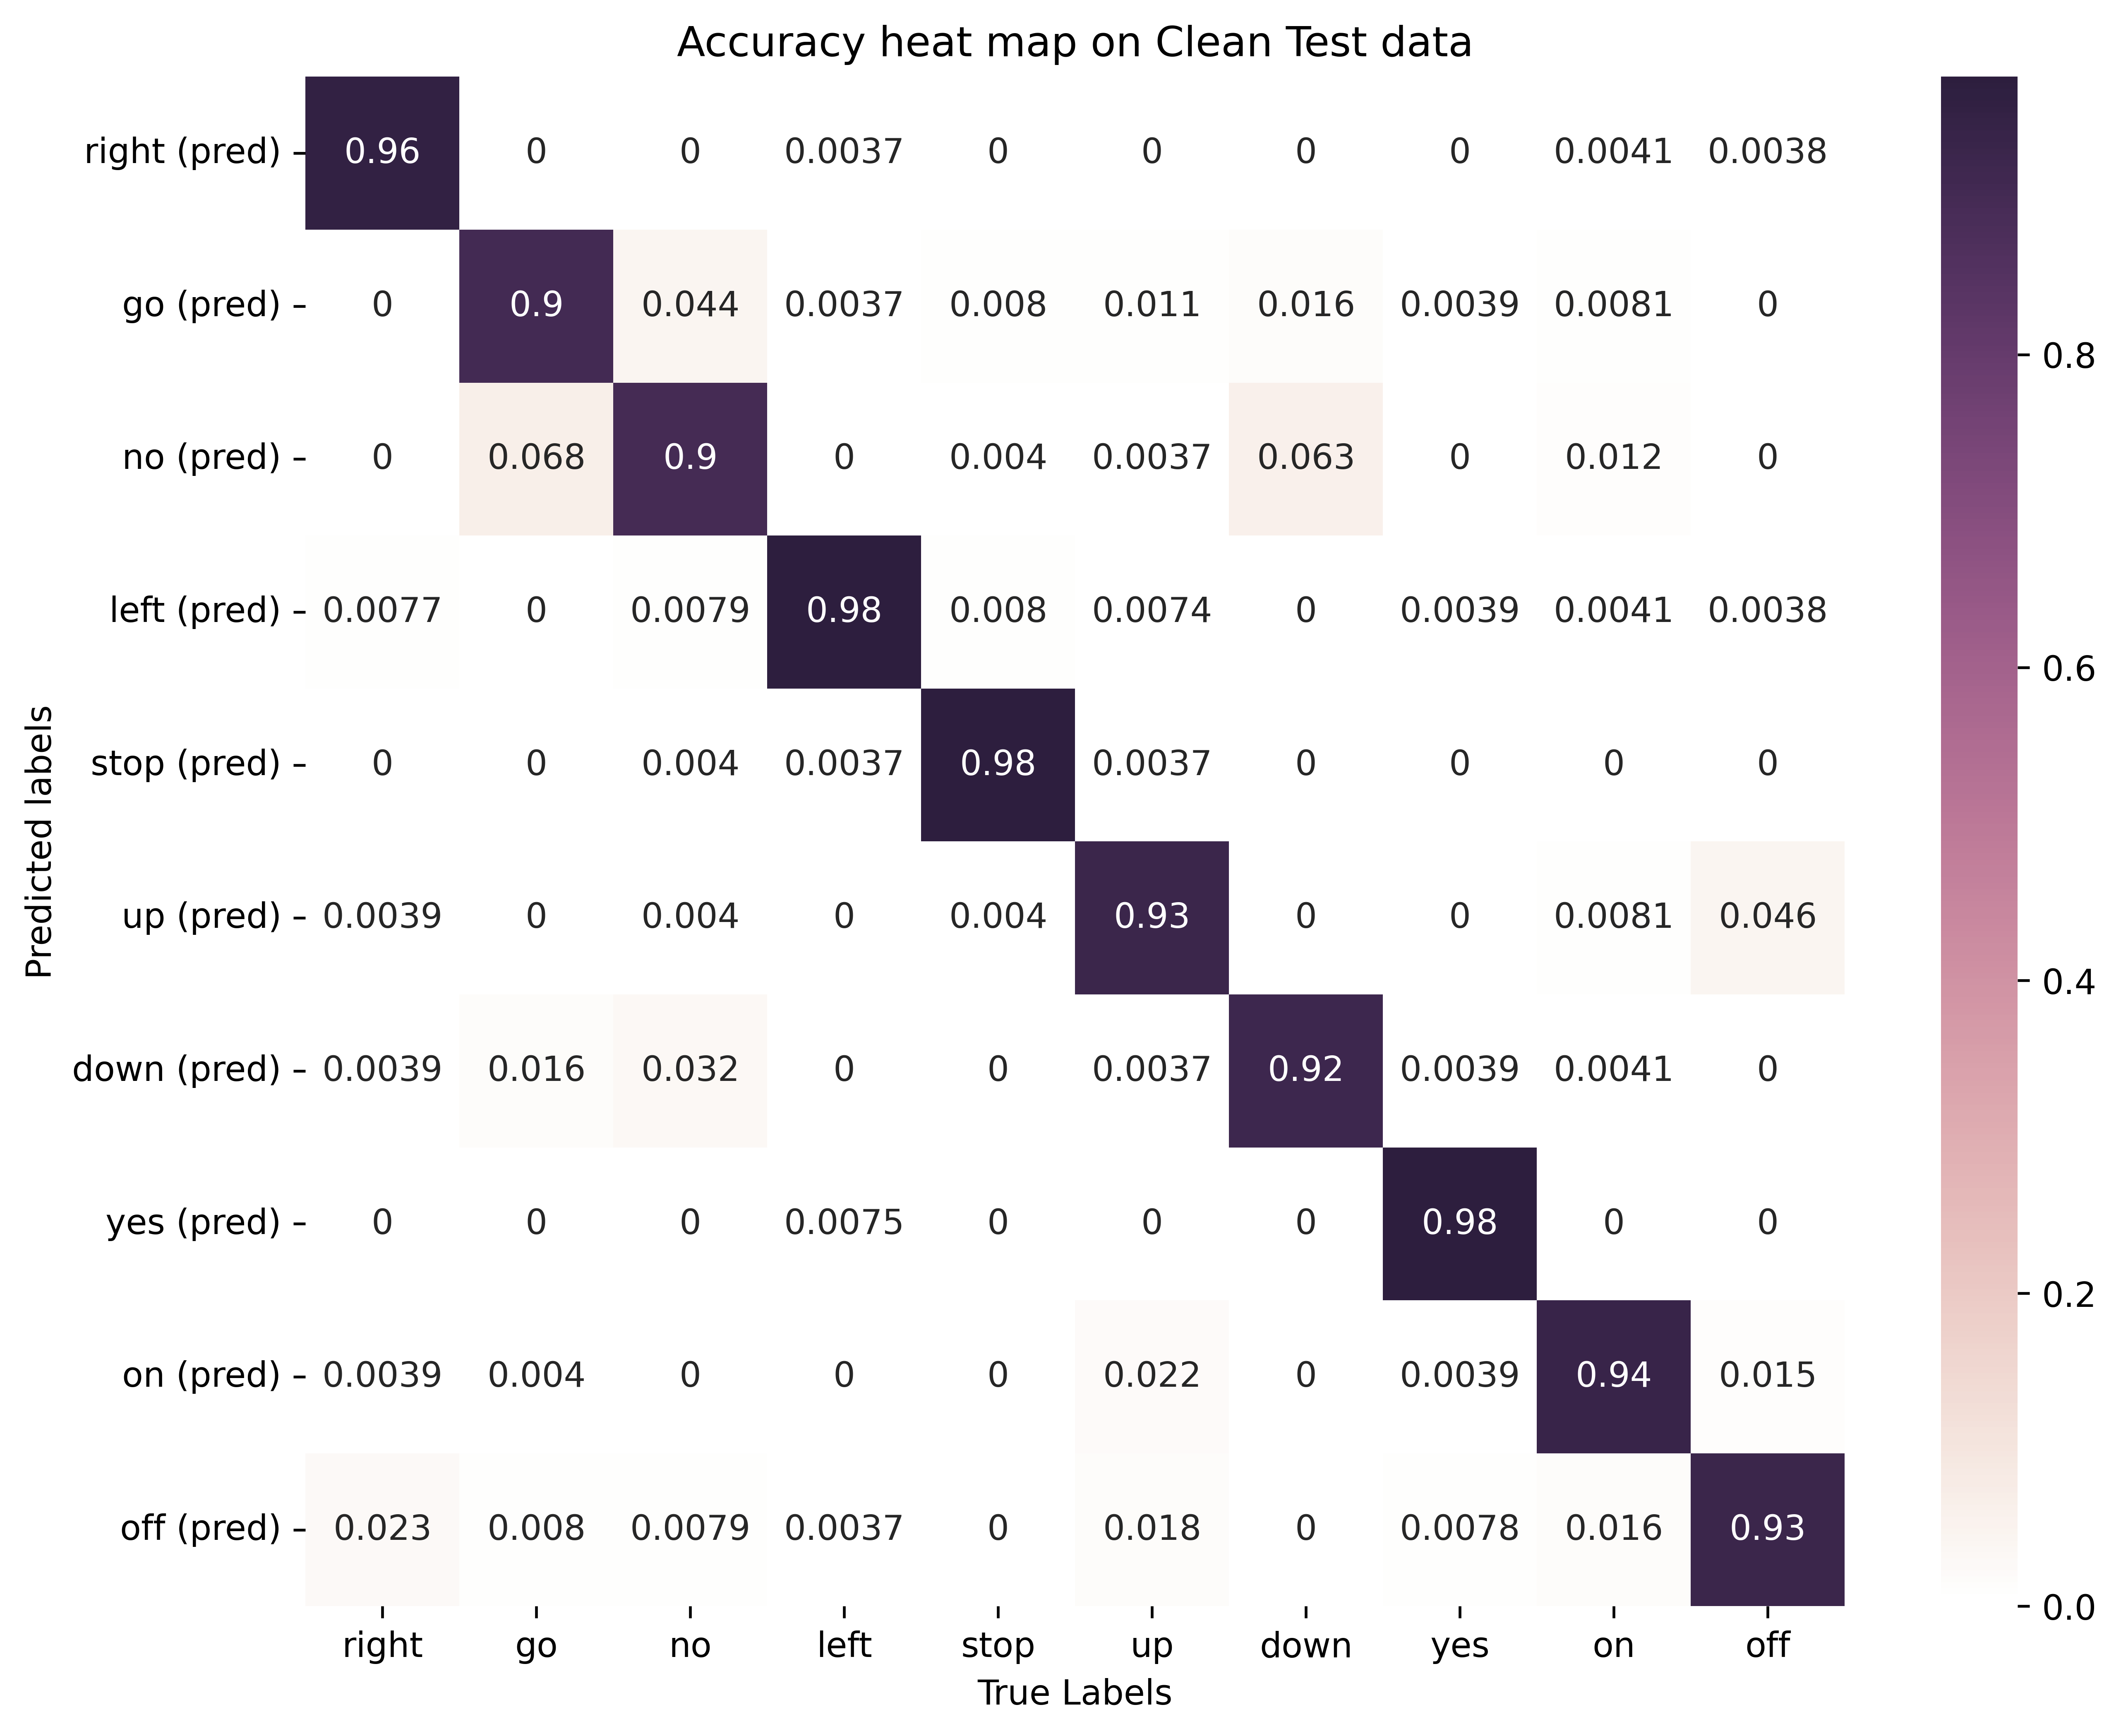

In [ ]:
plt.rcParams['figure.dpi'] = 600
fig, ax = plt.subplots(figsize=(10, 8))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
s = sns.heatmap(df_noisy_accuracy_test_clean, cmap=cmap, annot=True)
s.set_xlabel('True Labels', fontsize=10)
s.set_ylabel('Predicted labels', fontsize=10)
s.set_title("Accuracy heat map on Clean Test data")
plt.show()

In [ ]:
#DataFrame for Noisy Test Accuracies
df_noisy_accuracy_test_noisy = pd.DataFrame.from_dict(noisy_accuracy_test_noisy)
dictLabels = {}
for i in range(len(trainLabels)):
    dictLabels[i] = trainLabels[i]+" (pred)"
df_noisy_accuracy_test_noisy = df_noisy_accuracy_test_noisy.rename(index=dictLabels)
df_noisy_accuracy_test_noisy

right        go        no      left      stop        up  \
right (pred)  0.938224  0.003984  0.000000  0.011236  0.000000  0.003676   
go (pred)     0.003861  0.844622  0.087302  0.018727  0.024096  0.018382   
no (pred)     0.011583  0.091633  0.825397  0.007491  0.012048  0.011029   
left (pred)   0.015444  0.007968  0.023810  0.910112  0.004016  0.018382   
stop (pred)   0.003861  0.011952  0.015873  0.003745  0.919679  0.084559   
up (pred)     0.000000  0.007968  0.011905  0.011236  0.008032  0.808824   
down (pred)   0.007722  0.015936  0.019841  0.003745  0.004016  0.003676   
yes (pred)    0.000000  0.000000  0.003968  0.026217  0.004016  0.000000   
on (pred)     0.011583  0.007968  0.003968  0.003745  0.012048  0.025735   
off (pred)    0.007722  0.007968  0.007937  0.003745  0.012048  0.025735   

                  down       yes        on       off  
right (pred)  0.000000  0.000000  0.012195  0.007634  
go (pred)     0.094862  0.003906  0.012195  0.003817  
no (pred)     0.142292  0.027344  0.008130  0.003817  
left (pred)   0.007905  0.031250  0.008130  0.007634  
stop (pred)   0.007905  0.000000  0.004065  0.030534  
up (pred)     0.003953  0.007812  0.008130  0.076336  
down (pred)   0.735178  0.011719  0.000000  0.000000  
yes (pred)    0.003953  0.914062  0.000000  0.000000  
on (pred)     0.003953  0.000000  0.894309  0.061069  
off (pred)    0.000000  0.003906  0.052846  0.809160

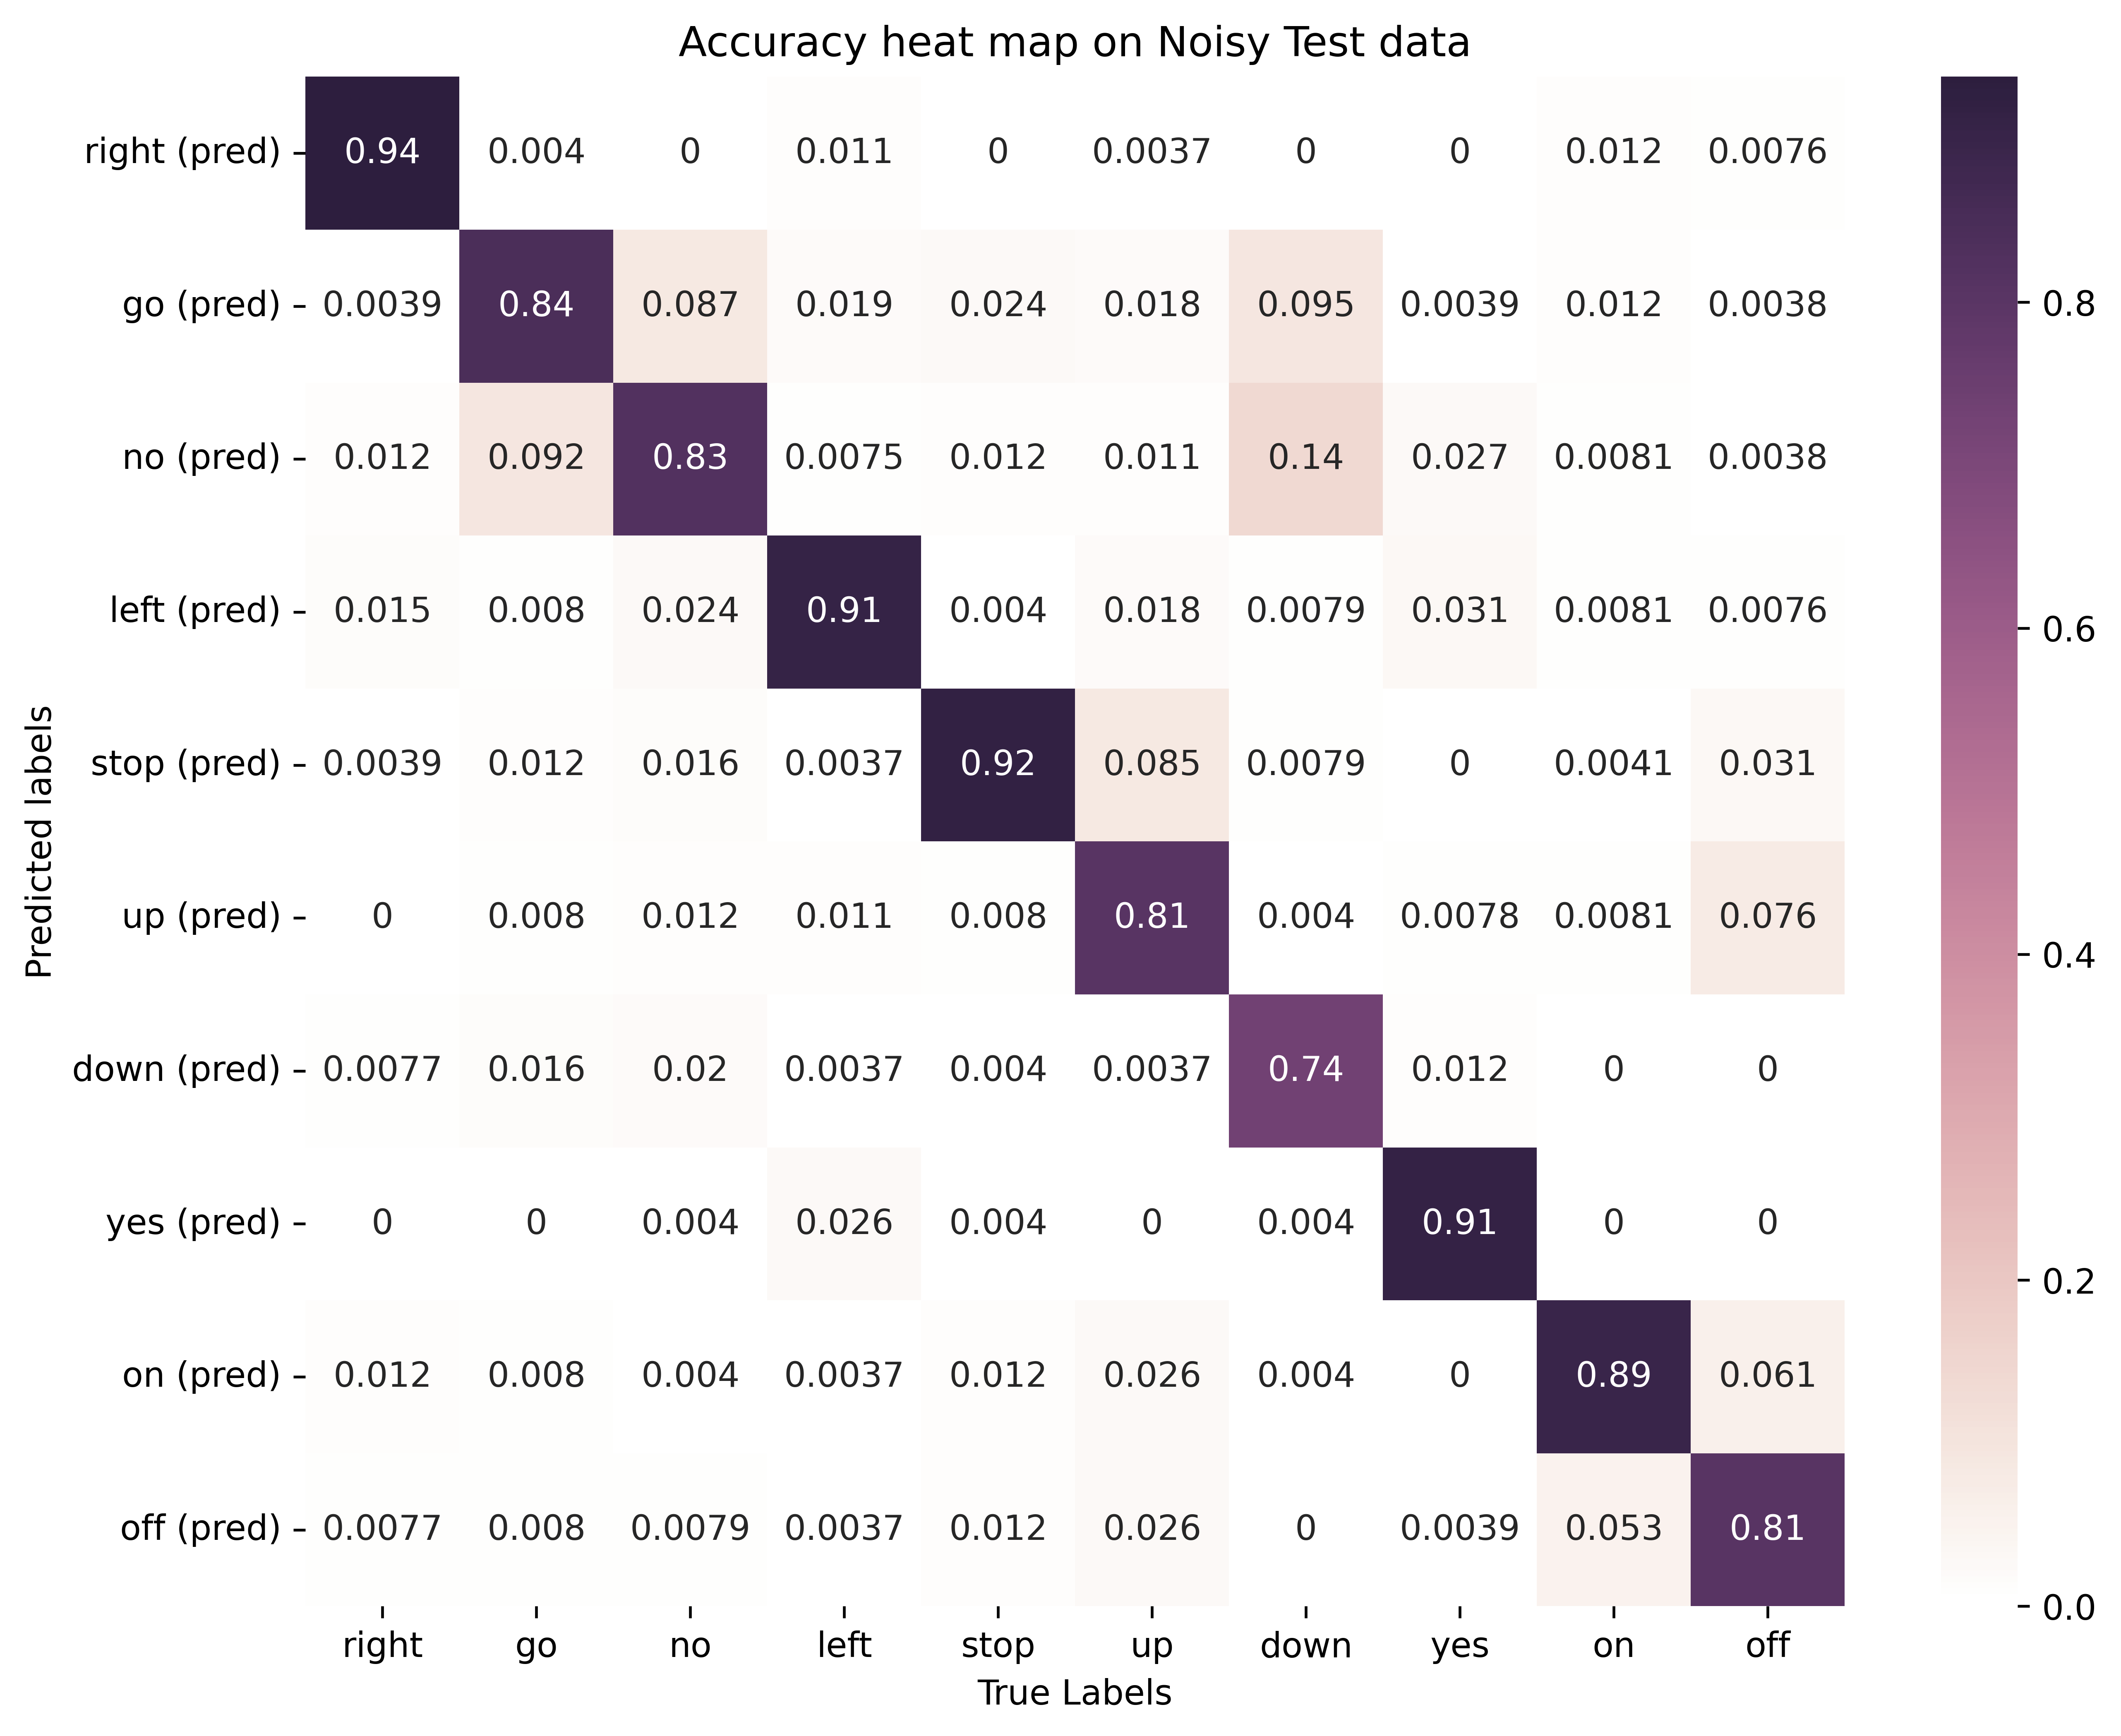

In [ ]:
plt.rcParams['figure.dpi'] = 600
fig, ax = plt.subplots(figsize=(10, 8))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
s = sns.heatmap(df_noisy_accuracy_test_noisy, cmap=cmap, annot=True)
s.set_xlabel('True Labels', fontsize=10)
s.set_ylabel('Predicted labels', fontsize=10)
s.set_title("Accuracy heat map on Noisy Test data")
plt.show()

# Observations

## Our HMM-GMM model trained on Noisy test data with any among 6 noise types added to half the samples equiprobably performs much better on the Noise Test Data, with mean accuracy = 0.86, minimum accuracy as 0.74 and maximum accuracy as 0.94.
## As expected these models doesn't perform as well on the Clean Test Data as the previous models trained only on clean Train Data, with mean accuracy = 0.942, minimum accuracy as 0.90 and maximum accuracy as 0.99. However the decrease in performance is not as significant as compared to the impressive increased accuracy on noisy Test Data